# Alzheimer prediction using gray matter density from T1w MRI 

**Deadline**: Upload this notebook (rename it as 'TP4-Trees-YOUR-SURNAME.ipynb') with your answers and code to the Moodle/Ecampus before the deadline.


We will use a dataset composed of neuroimaging features from brain T1w MR images of 752 subjects, 416 controls and 336 with Alzheimer’s disease. Following the pipeline described in [1], all images are first normalized to a
common space, providing a voxel-wise correspondence across subjects. Then, gray matter density is computed at each voxel and averaged over a set of ROIs (Region of Interest) of an atlas, at the beginning you will use the [AAL2 atlas](http://www.gin.cnrs.fr/en/tools/aal/). Data comes from several freely available datasets, like [ADNI](http://adni.loni.usc.edu/) and [OASIS](https://www.oasis-brains.org/), and has been pre-processed by the [Clinica](http://www.clinica.run/) team using the procedure explained in [1].

Please load the data from the file: *dataTP.npz* where *T1xxxx* is a matrix containing the averaged density (each row is a subject and each column a feature), *y* is a vector containing the diagnosis (0 for controls and 1 for Alzheimer’s patients) and *ROIlabelsx* contains the name of the ROI of each feature. Here, *x* can take the name of the three atlases you have at your disposal: AAL2, [AICHA](http://www.gin.cnrs.fr/fr/outils/aicha/), [HAMMERS](https://brain-development.org/brain-atlases/adult-brain-atlases/).

**Reference**:
[1] J. Samper-González, N. Burgos, S. Bottani, S. Fontanella, P. Lu, A. Marcoux, A. Routier, J. Guillon, M. Bacci, J. Wen, A. Bertrand, H. Bertin, M.-O. Habert, S. Durrleman, T. Evgeniou, O. Colliot. *Reproducible evaluation of classification methods in Alzheimer's disease: framework and application to MRI and PET data*. NeuroImage, 2018 

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import warnings
warnings.filterwarnings('ignore', category=ImportWarning)

# Libraries
import numpy as np
import matplotlib.pyplot as plt
!pip install -q nilearn
from nilearn import plotting
%matplotlib inline
np.random.seed(seed=666)

from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 38.0 MB/s eta 0:00:00


In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='11cQmPm64k3T7ml5fPLetZgb1j1AjHBH8',
dest_path='./dataTP.npz')
gdd.download_file_from_google_drive(file_id='1S7e5IrPygE4VV0JTwqJIlyO2S_NhsiI4',
dest_path='./AtlasAAL2.nii')
gdd.download_file_from_google_drive(file_id='1E0pu5jIMpgcs2DQ8lBGWliwEBZvKrnV9',
dest_path='./AtlasAICHA.nii')
gdd.download_file_from_google_drive(file_id='1yltKwULrkHYh79RAh_zAg08r8pQMjRlQ',
dest_path='./AtlasHAMMERS.nii')

with np.load('./dataTP.npz',allow_pickle=True) as data:
    T1AAL2 = data['T1AAL2'] # data from AAL2 Atlas
    T1AICHA = data['T1AICHA'] # data from AICHA Atlas
    T1HAMMERS = data['T1HAMMERS'] # data from HAMMERS Atlas  
    y = data['y'] # classes, 0 for controls and 1 for patients    
    ROIlabelsAAL2 = data['ROIlabelsAAL2'] # labels for ROIs of atlas AAL2 
    ROIlabelsAICHA = data['ROIlabelsAICHA']    # labels for ROIs of atlas AICHA 
    ROIlabelsHAMMERS = data['ROIlabelsHAMMERS']    # labels for ROIs of atlas HAMMERS 

In [ ]:
# Choose Atlas (here AAL2)
X=T1AAL2 # T1AAL2, T1AICHA, T1HAMMERS
labels=ROIlabelsAAL2 # ROIlabelsAAL2, ROIlabelsAICHA, ROIlabelsHAMMERS
atlas='./AtlasAAL2.nii' #AtlasAAL2.nii, AtlasAICHA.nii, AtlasHAMMERS.nii

N,M = X.shape # number subjects and ROIs
class_names = ["control","alzheimer"] # y=0, y=1

print('Number of controls and Alzheimer patients is respectively: {0} and {1}'.format(N-np.sum(y), np.sum(y)))
print('Number of ROI (features) is: {0}'.format(M))

Number of controls and Alzheimer patients is respectively: 416.0 and 336.0
Number of ROI (features) is: 120


Using the library nilearn we can also plot the atlas used to define the ROIs:

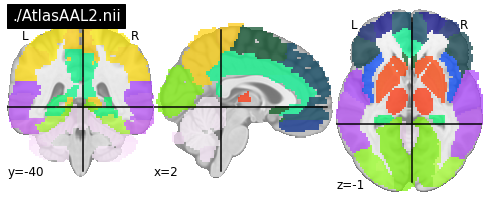

In [ ]:
plotting.plot_roi(atlas, title=atlas)
plotting.show()

In this TP we will use Decision Trees, Bagging and Random Forests. Let's start with Decision Trees. First of all, we need to create a training and test set.

In [ ]:
# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, np.ravel(y), test_size=0.33, random_state=42)

And then we need to check whether our features need to be standardized or normalized. Let's have a look at them. Remember that if features can have both negative and positive values, as a rule of thumb, they should be standardized. If they only have positive values, a normalization is usually used. 

As already said, please remember that you should learn the standardization/normalization (namely learn the average/std or the max/min values) ONLY in the training set and then use the same values also in the test set. You should NOT use the entire dataset (both training and test) for standardization/normalization. Otherwise, you would have a *data leakage*, namely you would use data (the test set) that you should not use during training. 

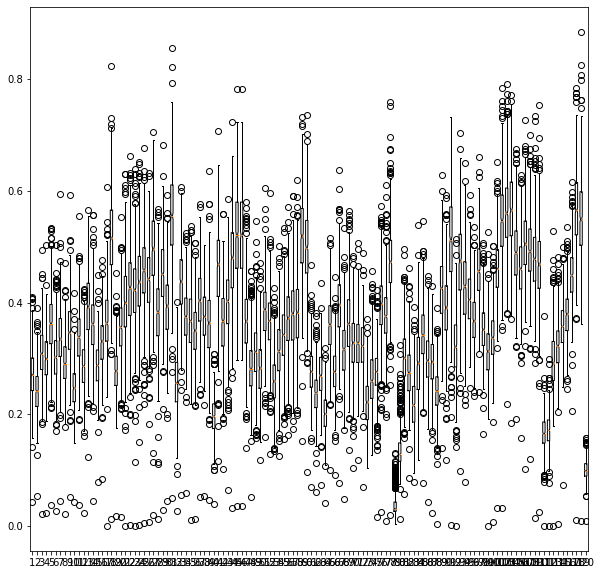

In [ ]:
plt.figure(figsize=(10,10))
plt.boxplot(X,notch=True);

In [ ]:
# Standardization/Normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# We will normalize the data since it is positive
normalizer = MinMaxScaler()
normalizer.fit(X_train)
X_train_normalize=normalizer.transform(X_train)
X_test_normalize=normalizer.transform(X_test)

Then, we can fit a Decision tree, with the default setting, using the following code:

In [ ]:
# Fitting Decision Trees 
Tree = DecisionTreeClassifier(random_state=0)
Tree.fit(X_train_normalize,y_train)
# Score in the training set
print('Score in the training set is {0}'.format(Tree.score(X_train_normalize,y_train)) )
# Score in the test set
print('Score in the test set is {0}'.format(Tree.score(X_test_normalize,y_test)) )

Score in the training set is 1.0
Score in the test set is 0.714859437751004


Instead than using the default hyperparameters, we could also look for the best ones. Among the hyperparameters implemented in *scikit-learn* we could use *'min_samples_split'*, the minimum number of samples required to split an internal node, and/or *'min_samples_leaf'*, the minimum number of samples required to be present at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. 

Plot the training and test score for different values of 'min_samples_split' (for instance between 2 and 15) WITHOUT using Cross Validation. Do the same for 'min_samples_leaf'.

**Question:** What is the best value ? What happens if you split differently your data (change `random_state`in the function `train_test_split`) ? 

**Ansewer:**

The best value of *min_samples_split*, considering the test score, was 12, and the best value of *min_samples_leaf* was 15. Changing the data split between test and training sets those values varied slightly.

The value of min_samples_split that maximizes the training score is :  2
The value of min_samples_split that maximizes the test score is :  12


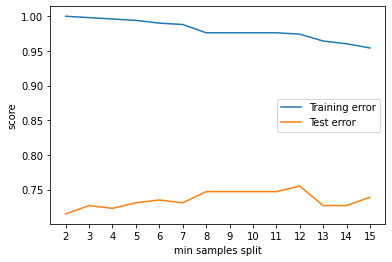

In [ ]:
# min_samples_split

TTest=[]
TTrain=[]
for i in range(2,16):
    Tree = DecisionTreeClassifier(min_samples_split=i, random_state=0)
    Tree.fit(X_train_normalize, y_train)
    scoreTrain=Tree.score(X_train_normalize, y_train)
    scoreTest=Tree.score(X_test_normalize, y_test)
    TTrain.append(scoreTrain)
    TTest.append(scoreTest)
plt.plot(TTrain,label='Training error');
plt.xticks(np.arange(14), ('2', '3', '4', '5', '6','7','8','9','10','11','12','13','14','15'))
print("The value of min_samples_split that maximizes the training score is : ",TTrain.index(max(TTrain))+2)
plt.plot(TTest,label='Test error');
plt.xticks(np.arange(14), ('2', '3', '4', '5', '6','7','8','9','10','11','12','13','14','15'))
plt.xlabel('min samples split')
plt.ylabel('score')
print("The value of min_samples_split that maximizes the test score is : ",TTest.index(max(TTest))+2)
plt.legend();

The value of min_samples_split that maximizes the training score is :  2
The value of min_samples_split that maximizes the test score is :  15


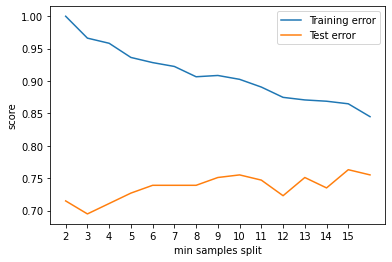

In [ ]:
# min_samples_leaf
TTest=[]
TTrain=[]
for i in range(1,16):
    Tree = DecisionTreeClassifier(min_samples_leaf=i, random_state=0)
    Tree.fit(X_train_normalize, y_train)
    scoreTrain=Tree.score(X_train_normalize, y_train)
    scoreTest=Tree.score(X_test_normalize, y_test)
    TTrain.append(scoreTrain)
    TTest.append(scoreTest)
plt.plot(TTrain,label='Training error');
plt.xticks(np.arange(14), ('2', '3', '4', '5', '6','7','8','9','10','11','12','13','14','15'))
print("The value of min_samples_split that maximizes the training score is : ",TTrain.index(max(TTrain))+2)
plt.plot(TTest,label='Test error');
plt.xticks(np.arange(14), ('2', '3', '4', '5', '6','7','8','9','10','11','12','13','14','15'))
plt.xlabel('min samples split')
plt.ylabel('score')
print("The value of min_samples_split that maximizes the test score is : ",TTest.index(max(TTest))+2)
plt.legend();

Try to add Gaussian noise to the data (using for instance zero mean and 0.05 for $\sigma$) and, using the best hyperparameters found before in the test set (you can use both `min_samples_leaf` and `min_samples_split`), look at the test score. Repeat this process several times and compare the results with the score obtained without adding noise. 

**Question**: Are the results stable ? Hint: you could use for instance *noise = np.random.normal(mu, sigma)* if you have standardized the features and *noise = np.abs(np.random.normal(mu, sigma))* if you have normalized them (we use *np.asb()* to take only positive values and $\sigma$ should be small in order to (almost) preserve the range of the features between 0 and 1)

**Answer:** The results are not stable, which reflects the fact that decision trees have high variance.

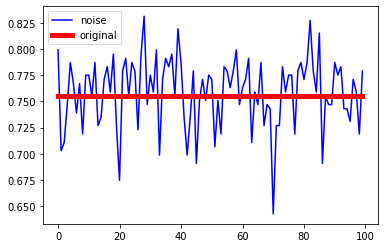

In [ ]:
Tree = DecisionTreeClassifier(min_samples_split=12, min_samples_leaf=15, random_state=0)
scoreTestnoise=np.zeros(100)
scoreTest=np.zeros(100)

Tree.fit(X_train_normalize, y_train)
scoreTest[:] = Tree.score(X_test_normalize, y_test)  

mu = 0
sigma = 0.05

for k in range(100):    
    X_train_temp=np.copy(X_train_normalize) # X_train_temp=np.copy(X_train)
    # for i in range(X_train.shape[0]):
    #     X_train_temp[i] XXXXXXXXXXX
    X_train_temp += np.abs( np.random.normal(mu, sigma, size=X_train_temp.shape) )
        
    Tree.fit(X_train_temp, y_train)
    scoreTestnoise[k] = Tree.score(X_test_normalize, y_test)
    
plt.plot(scoreTestnoise,'b',label='noise')
plt.plot(scoreTest,'r',linewidth=5.0,label='original')       
plt.legend();

To plot decision trees, we can also use the *graphviz* library. If you need to install it locally, you can do it using *conda install python-graphviz*. 
 

First plot the tree learnt on the original data, witout adding noise.

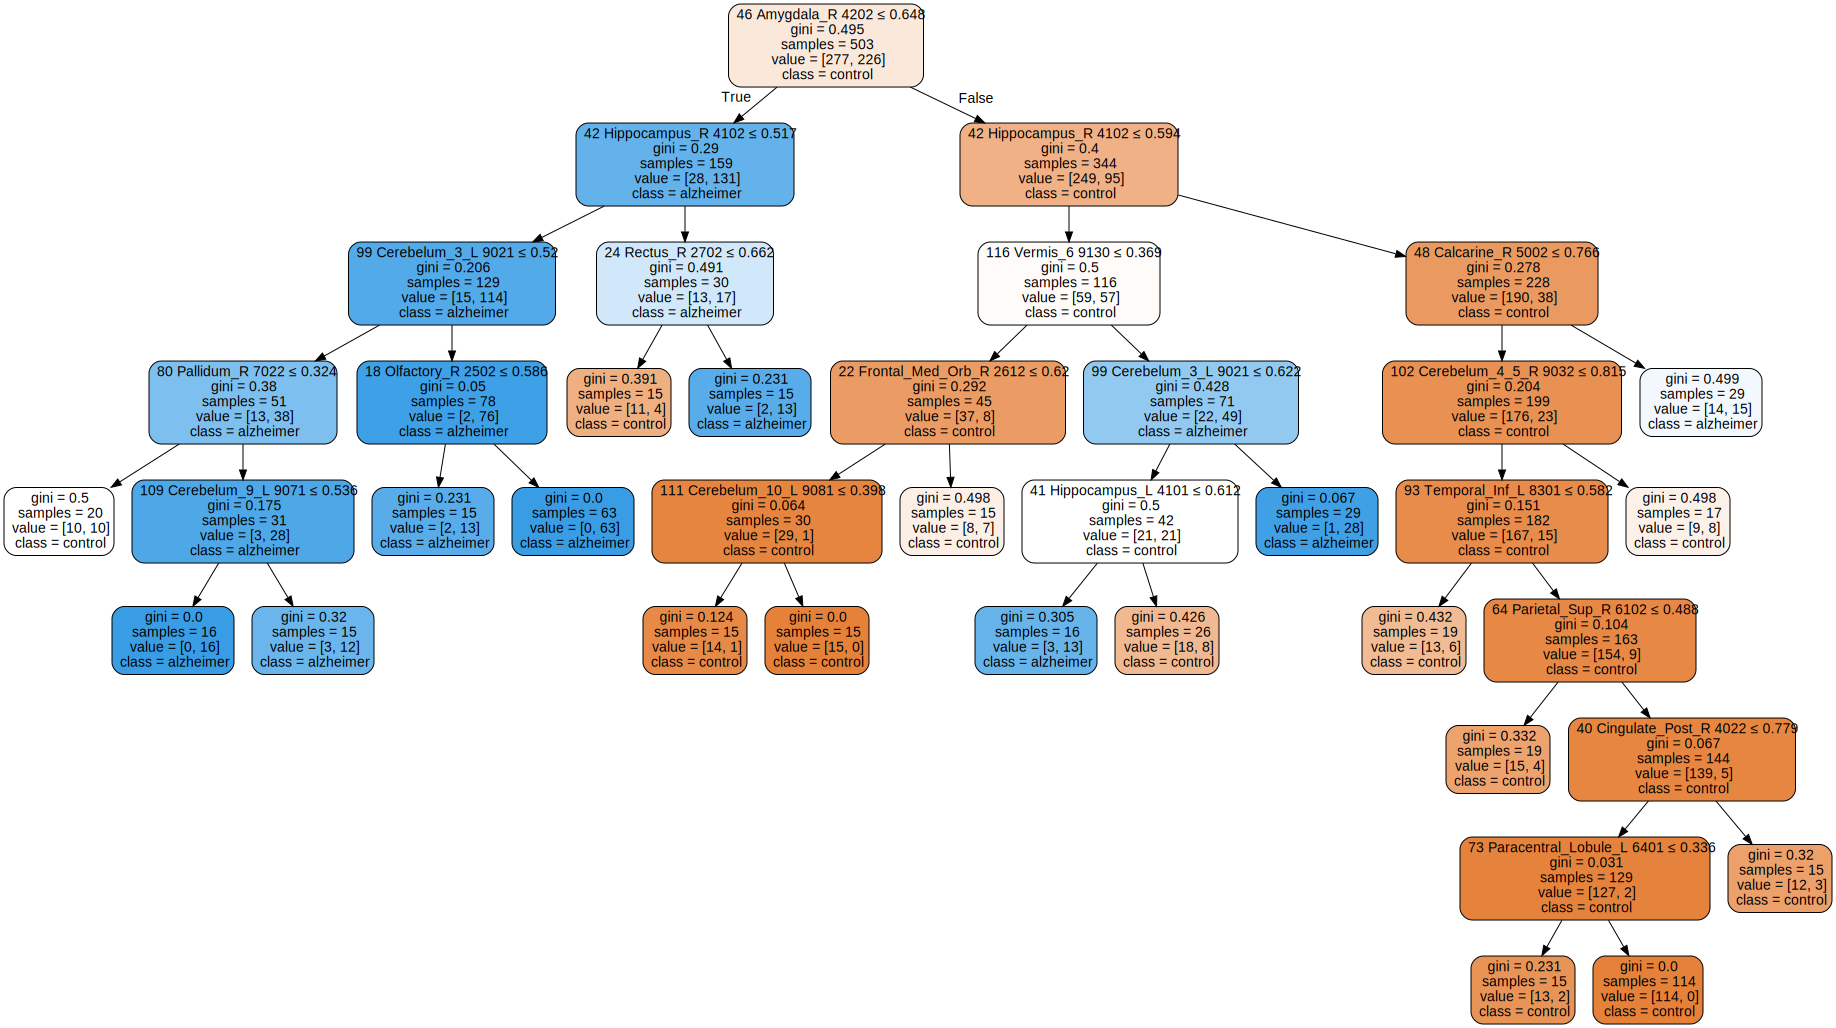

In [ ]:
import graphviz 

Tree.fit(X_train_normalize,y_train)
dot_data = tree.export_graphviz(Tree, out_file=None,feature_names=labels,class_names=class_names,filled=True, rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)
graph

Now, plot the tree learnt on noisy data.

**Question**: Is it the same ? You can try several times, for different levels of noise. Comment the results

**Answer:** We see that the trees learnt on the original data and on the noisy data (for different levels of noise) are not the same, which reflects the fact that the decision tree model has high variance. The features used to split the nodes are different, as well as the depth of the trees. In fact, the trees learnt on noisy data are deeper, which might be due to the fact that noise corrupts the data, making it "harder to learn", thus more splits are needed to adjust to the data.

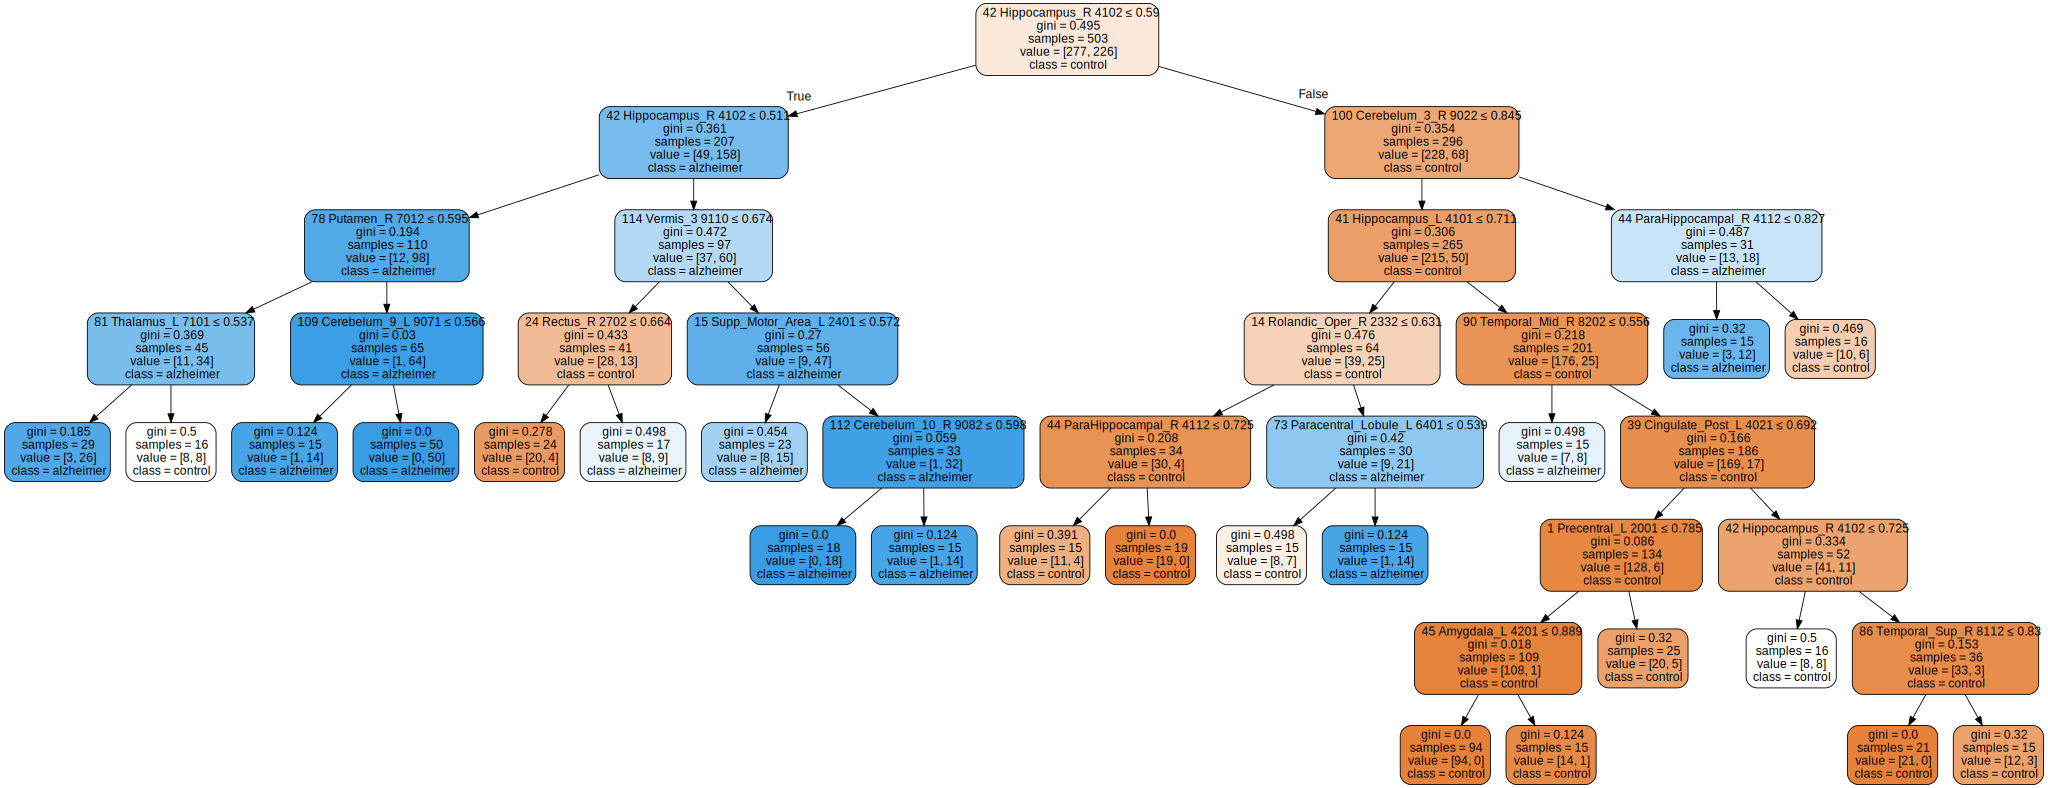

In [ ]:
mu = 0
sigma = 0.05
X_train_temp=np.copy(X_train_normalize)
X_train_temp += np.abs( np.random.normal(mu, sigma, size=X_train_temp.shape) )
Tree.fit(X_train_temp, y_train)

dot_data = tree.export_graphviz(Tree, out_file=None,feature_names=labels,class_names=class_names,filled=True, rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)
graph

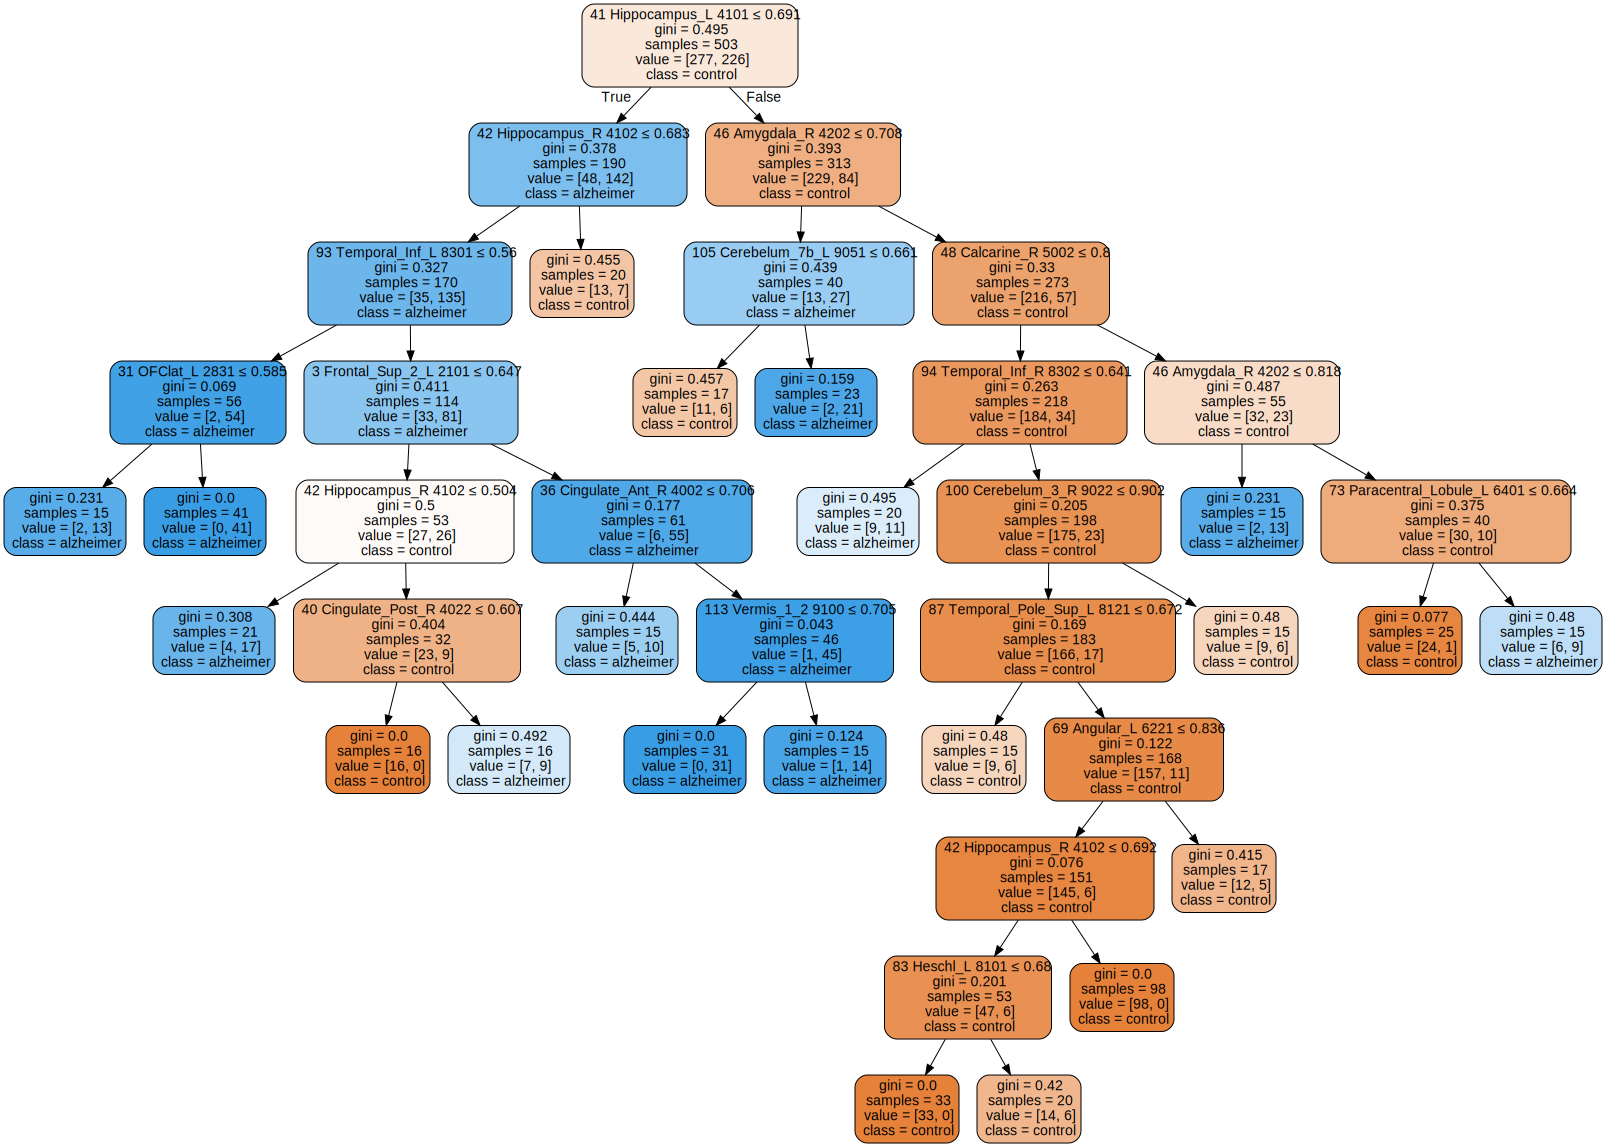

In [ ]:
mu = 0
sigma = 0.1
X_train_temp=np.copy(X_train_normalize)
X_train_temp += np.abs( np.random.normal(mu, sigma, size=X_train_temp.shape) )
Tree.fit(X_train_temp, y_train)

dot_data = tree.export_graphviz(Tree, out_file=None,feature_names=labels,class_names=class_names,filled=True, rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)
graph

Instead than using a single split of the data, we could also use Cross Validation to compute the best hyperparameter values for both 'min_samples_split' and 'min_samples_leaf' at the same time and in an automatic way. 

**Question:** Do you find the same optimal hyperparameters as before ? Hint: use GridSearchCV

**Answer:** The best values are quite different then before, now the best value for *min_samples_leaf* is 9 and for *min_samples_split* is 2; it is worthwhile noticing that now the two hyperparameters are being optimized simultaneously while before they were optimized independently.

**Question**: So far, we have used the standard score (ie accuracy). Would you use a different one ? If yes, which one and why ?

**Answer:** Considering that the data is slightly unbalanced (416 negatives versus 336 positives), it might be better to use balanced accuracy rather then accuracy, since we do not want to bias the model towards making negative predictions. On the other hand, from a medical standpoint it is more important to reduce the false negative rate rather then the overall fraction of correct predictions, thus the F1 score could be well suited.

In [ ]:
Tree = DecisionTreeClassifier(random_state=0)
p_grid_tree = {'min_samples_split': list(range(2,16)),
               'min_samples_leaf': list(range(1,16))} 
grid_tree = GridSearchCV(Tree, p_grid_tree, cv=5, n_jobs=1)
grid_tree.fit(X_train_normalize, y_train)
print("Best Validation Score: {}".format(grid_tree.best_score_))
print("Best params: {}".format(grid_tree.best_params_))
print("Tree test score :",grid_tree.score(X_test_normalize, y_test))

best_params=grid_tree.best_params_

Best Validation Score: 0.7575049504950495
Best params: {'min_samples_leaf': 9, 'min_samples_split': 2}
Tree test score : 0.7550200803212851


Using the estimated optimal hyperparameers, plot the new decision tree using the *graphviz* library. 

**Question**: Is it the same as before? Do you see ROIs that are always close to the root of the tree among the different experiments ? If yes, what does it mean in your opinion ? Comment the results.

**Answer:** The tree is not the same as before, however despite the differences, there are ROIs that are always close to the root of the tree, such as the Amygdala and the Hippocampus, which indicates that those features might be more important for the classification task.

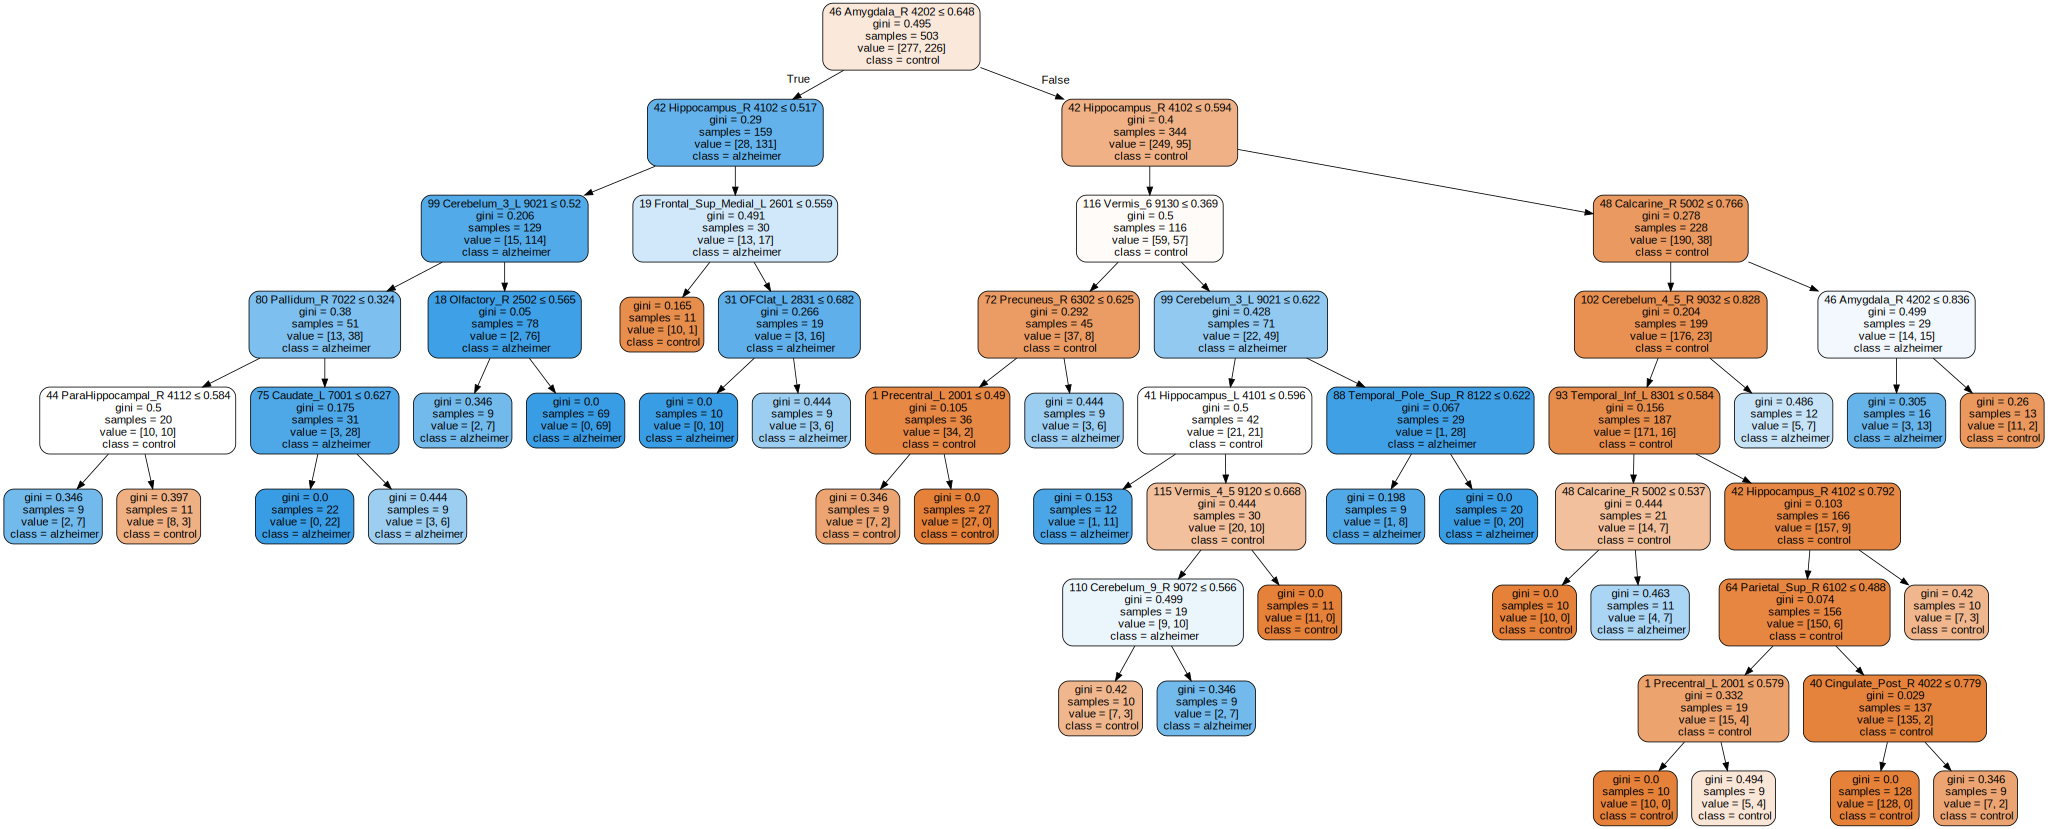

In [ ]:
dot_data = tree.export_graphviz(grid_tree.best_estimator_, out_file=None,feature_names=labels,class_names=class_names,filled=True, rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)
graph

Try to use now Bagging. You can use the following code where we use the previously computed best parameters 'min_samples_leaf' and 'min_samples_split'. 

**Question**: What happens when you use the original data and the noisy version ? Do you notice any difference in the prediction scores with respect to the results using Decision Trees ? 

**Answer:** We see that the results are stable when using the original data or the noisy version, which is expected since bagging reduces the variance. Also the test score was improved when compared to the use of Decision Trees, because when we combine several possibly weak learners we can create a more accurate one (Condorcet's jury theorem).

In [ ]:
Tree = DecisionTreeClassifier(min_samples_leaf=best_params["min_samples_leaf"],min_samples_split=best_params["min_samples_split"], random_state=0)

p_grid_bagging = {'n_estimators': [5,10,15,20]}      
bag=BaggingClassifier(estimator=Tree, random_state=0)
grid_bagging = GridSearchCV(bag, p_grid_bagging, cv=5, n_jobs=1)
grid_bagging.fit(X_train_normalize, y_train)
print("Best Validation Score: {}".format(grid_bagging.best_score_))
print("Best params: {}".format(grid_bagging.best_params_))
print("Bagging test score :",grid_bagging.score(X_test_normalize,y_test))

Best Validation Score: 0.7874455445544555
Best params: {'n_estimators': 15}
Bagging test score : 0.8232931726907631


In [ ]:
# Bagging on noisy data
mu = 0
sigma = 0.05
X_train_temp=np.copy(X_train_normalize)
X_train_temp += np.abs( np.random.normal(mu, sigma, size=X_train_temp.shape) )

grid_bagging.fit(X_train_temp, y_train)
print("Best Validation Score: {}".format(grid_bagging.best_score_))
print("Best params: {}".format(grid_bagging.best_params_))
print("Bagging test score :",grid_bagging.score(X_test_normalize,y_test))

Best Validation Score: 0.7873465346534654
Best params: {'n_estimators': 15}
Bagging test score : 0.8112449799196787


The last part of this TP is about Random Forests. We can estimate the three hyperparameters *'n_estimators'*, *'min_samples_leaf'* and *'max_features'*, the number of features to consider when looking for the best split, as before using Cross Validation

In [ ]:
RF=RandomForestClassifier(random_state=0)
p_grid_RF = {'n_estimators': [10,15,20,25,30], 'min_samples_leaf': [2,3,4,5,6], 'max_features': ['sqrt','log2']}   

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring='balanced_accuracy', cv=5) 
grid_RF.fit(X_train_normalize, y_train)

print("Best Validation Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
print("Random Forest test score :",grid_RF.score(X_test_normalize,y_test))

Best Validation Score: 0.8090667545015371
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 30}
Random Forest test score : 0.8335513407455855


Using the estimated best hyperparameters, test the performance of Random Forest on the noisy data and compare the results with Decision Trees and Bagging. 

In [ ]:
# Random Forest on noisy data
mu = 0
sigma = 0.05
X_train_temp=np.copy(X_train_normalize)
X_train_temp += np.abs( np.random.normal(mu, sigma, size=X_train_temp.shape) )

grid_RF.fit(X_train_temp, y_train)

print("Best Validation Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
print("Random Forest test score :",grid_RF.score(X_test_normalize,y_test))

Best Validation Score: 0.7861663216011042
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 3, 'n_estimators': 25}
Random Forest test score : 0.7968279921517332


We can also use Random Forests to check the importance of the features

Feature ranking:
1. feature 45 representing 46 Amygdala_R 4202
 (0.088545)
2. feature 41 representing 42 Hippocampus_R 4102
 (0.066296)
3. feature 40 representing 41 Hippocampus_L 4101
 (0.061631)
4. feature 43 representing 44 ParaHippocampal_R 4112
 (0.053690)
5. feature 44 representing 45 Amygdala_L 4201
 (0.034586)
6. feature 93 representing 94 Temporal_Inf_R 8302
 (0.029686)
7. feature 92 representing 93 Temporal_Inf_L 8301
 (0.026633)
8. feature 81 representing 82 Thalamus_R 7102
 (0.023548)
9. feature 47 representing 48 Calcarine_R 5002
 (0.022417)
10. feature 18 representing 19 Frontal_Sup_Medial_L 2601
 (0.019670)


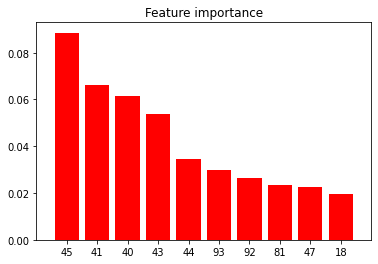

In [ ]:
best_params=grid_RF.best_params_
RF = RandomForestClassifier(min_samples_leaf=best_params["min_samples_leaf"],max_features=best_params["max_features"],n_estimators=best_params["n_estimators"], random_state=0)
RF.fit(X_train_normalize,y_train)

importances = RF.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d representing %s (%f)" % (f + 1, indices[f], labels[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importance")
plt.bar(range(10), importances[indices[0:10]], color="r", align="center")
plt.xticks(range(10), indices[0:10])
plt.xlim([-1, 10])
plt.show()

**Question**: Which are the most important features (i.e. ROIs) ?  Based on the two given research papers, you can verify if your results make sense. 

**Answer:** The brain regions that appear among the ten most important features are the amygdala, the hippocampus, the parahippocampal cortex, the inferior temporal cortex, the thalamus, the calcarine and the medial superior frontal cortex. Based on the research papers, those results make sense, since in those papers it is said:
- AD affects brain regions well beyond the
hippocampus, such as atrophy of the entorhinal cortex (Dickerson
et al., 2001), expansion of the ventricles (Ridha et al., 2008), and volumetric changes in other subcortical nuclei (amygdala, putamen,
caudate, and thalamus). [*A review on neuroimaging-based classification studies and associated feature extraction methods for Alzheimer's disease and its prodromal stages*]
- Neurobiological
changes occur years before symptoms appear, with a stereotypical pattern of early medial
temporal lobe (entorhinal cortex and hippocampus) involvement, followed by progressive neocortical damage. [*The clinical use of structural MRI in Alzheimer disease*]

We can also inspect the data using only pairs of the most important features

Score of pair [45, 41]: 0.7831325301204819
Score of pair [45, 40]: 0.8112449799196787
Score of pair [45, 43]: 0.7791164658634538
Score of pair [41, 40]: 0.7590361445783133
Score of pair [41, 43]: 0.7550200803212851
Score of pair [40, 43]: 0.7710843373493976


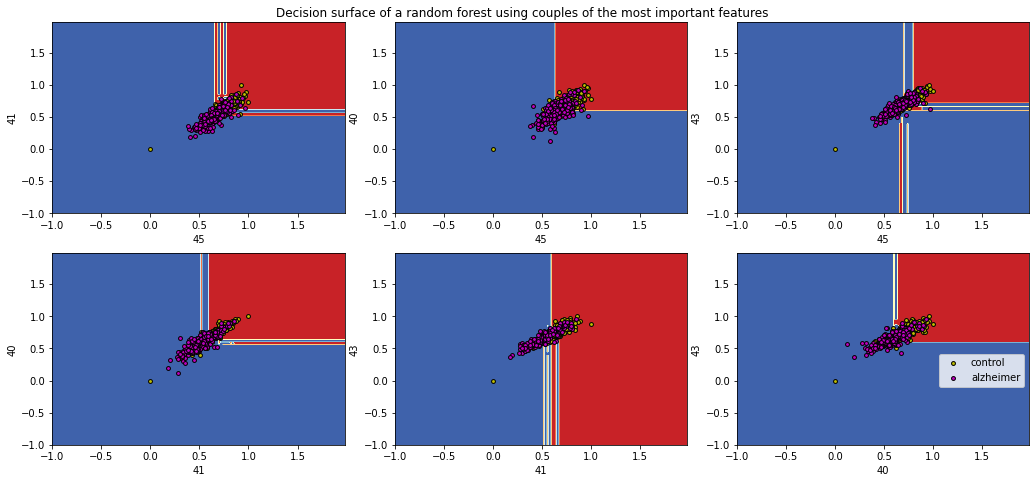

In [ ]:
plt.figure(figsize=(15,7))
for pairidx, pair in enumerate([ [indices[0],indices[1]], [indices[0],indices[2]], [indices[0],indices[3]],
                                [indices[1],indices[2]], [indices[1],indices[3]], [indices[2],indices[3]] ]):
    # We only take the two corresponding features
    Xpair = X_train_normalize[:, pair]
    Xpair_test = X_test_normalize[:, pair]
    ypair = y_train

    # Train
    clf = RF.fit(Xpair, ypair)
    score = RF.score(Xpair_test, y_test)
    print("Score of pair {}: {}".format(pair, score))

    # Plot the decision boundary
    plt.subplot(2, 3, pairidx + 1)

    x_min, x_max = Xpair[:, 0].min() - 1, Xpair[:, 0].max() + 1
    y_min, y_max = Xpair[:, 1].min() - 1, Xpair[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

    plt.xlabel(pair[0])
    plt.ylabel(pair[1])

    # Plot the training points
    for i, color in zip(range(2), "ym"):
        idx = np.where(ypair == i)
        plt.scatter(Xpair[idx, 0], Xpair[idx, 1], c=color, label=class_names[i], edgecolor='black', s=15) # cmap=plt.cm.RdYlBu

plt.suptitle("Decision surface of a random forest using couples of the most important features")
plt.legend(bbox_to_anchor=(1, 0.5))
plt.axis("tight")
plt.show()

**Question**: Which is the best couple of features ?

**Answer:** Based on the test scores, it seems that the best couple of features is (40, 45).

**Different Atlas**

Previously, we have used the AAL2 which defines a precise split of the brain into ROIs. What happens if you change Atlas ? Do you obtain the same results ? Can you find a subset of ROIs that you could define 'biomarkers' of the Alzheimer's disease ? Justify your answer and check whether it makes sense by using the two given research papers.

You can use the AICHA (http://www.gin.cnrs.fr/fr/outils/aicha/) and HAMMERS (https://brain-development.org/brain-atlases/adult-brain-atlases/) atlas.

**Answer:** With respect to the classification accuracy, the results for the different atlases are very close to each other, which agrees with the conclusion of the paper *Reproducible evaluation of classification methods in Alzheimer’s disease: framework and application to MRI and 
PET data*. Also, the most important features for the HAMMER atlas mostly agree with those of the AAL2 atlas, however the AICHA atlas gives quite different features. Based on the coincidences between the most important features for the AAL2 and HAMMER atlases, I would say the Amygdala and Hippocampus could be considered as biomarkers of the Alzheimer disease, which agrees with the paper *A review on neuroimaging-based classification studies and associated feature extraction methods for Alzheimer's disease and its prodromal stages*, where we can see that the Amygdala and Hippocampus are commonly used features to detect AD.

Number of controls and Alzheimer patients is respectively: 416.0 and 336.0
Number of ROI (features) is: 192


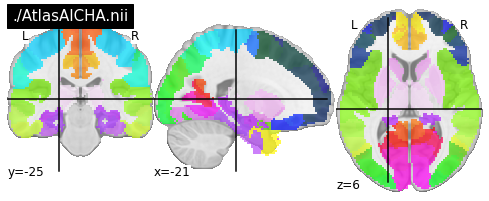

Best Validation Score: 0.7558783487044357
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 15}
Random Forest test score : 0.8053302812295617
Feature ranking:
1. feature 144 representing 145	S_Parietooccipital-4	146
 (0.081293)
2. feature 173 representing 174	N_Caudate-1	175
 (0.037795)
3. feature 187 representing 188	N_Thalamus-5	189
 (0.030753)
4. feature 145 representing 146	S_Parietooccipital-5	147
 (0.025472)
5. feature 170 representing 171	G_Fusiform-6	172
 (0.025103)
6. feature 189 representing 190	N_Thalamus-7	191
 (0.024759)
7. feature 74 representing 75	G_Insula-anterior-3	76
 (0.024081)
8. feature 182 representing 183	N_Putamen-3	184
 (0.021630)
9. feature 143 representing 144	S_Parietooccipital-3	145
 (0.019331)
10. feature 172 representing 173	N_Amygdala-1	174
 (0.018985)


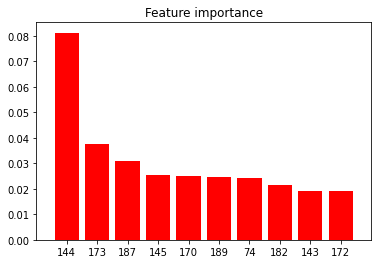

In [ ]:
# Choose Atlas (here AICHA)
X=T1AICHA # T1AAL2, T1AICHA, T1HAMMERS
labels=ROIlabelsAICHA # ROIlabelsAAL2, ROIlabelsAICHA, ROIlabelsHAMMERS
atlas='./AtlasAICHA.nii' #AtlasAAL2.nii, AtlasAICHA.nii, AtlasHAMMERS.nii

N,M = X.shape # number subjects and ROIs
class_names = ["control","alzheimer"] # y=0, y=1

print('Number of controls and Alzheimer patients is respectively: {0} and {1}'.format(N-np.sum(y), np.sum(y)))
print('Number of ROI (features) is: {0}'.format(M))

plotting.plot_roi(atlas, title=atlas)
plotting.show()

# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, np.ravel(y), test_size=0.33, random_state=42)

# We will normalize the data since it is positive
normalizer = MinMaxScaler()
normalizer.fit(X_train)
X_train_normalize=normalizer.transform(X_train)
X_test_normalize=normalizer.transform(X_test)

# Random Forest
RF=RandomForestClassifier(random_state=0)
p_grid_RF = {'n_estimators': [10,15,20,25,30], 'min_samples_leaf': [2,3,4,5,6], 'max_features': ['sqrt','log2']}   

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring='balanced_accuracy', cv=5) 
grid_RF.fit(X_train_normalize, y_train)

print("Best Validation Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
print("Random Forest test score :",grid_RF.score(X_test_normalize,y_test))

# Feature ranking
best_params=grid_RF.best_params_
RF = RandomForestClassifier(min_samples_leaf=best_params["min_samples_leaf"],max_features=best_params["max_features"],n_estimators=best_params["n_estimators"], random_state=0)
RF.fit(X_train_normalize,y_train)

importances = RF.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d representing %s (%f)" % (f + 1, indices[f], labels[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importance")
plt.bar(range(10), importances[indices[0:10]], color="r", align="center")
plt.xticks(range(10), indices[0:10])
plt.xlim([-1, 10])
plt.show()

Number of controls and Alzheimer patients is respectively: 416.0 and 336.0
Number of ROI (features) is: 68


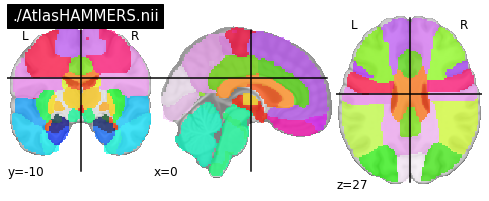

Best Validation Score: 0.7947241043980174
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 25}
Random Forest test score : 0.8343034663178548
Feature ranking:
1. feature 3 representing Right Amygdala                         (0.108175)
2. feature 2 representing Left Amygdala                          (0.069019)
3. feature 0 representing Left Hippocampus                       (0.065490)
4. feature 46 representing Left Lateral Temporal Ventricle        (0.051720)
5. feature 47 representing Right Lateral Temporal Ventricle       (0.047733)
6. feature 1 representing Right Hippocampus                      (0.046961)
7. feature 12 representing Left Inferior Middle Temporal Gyri     (0.031342)
8. feature 8 representing Left Ambient and Parahippocampus Gyri  (0.026882)
9. feature 40 representing Left Thalamus                          (0.019667)
10. feature 45 representing Right Corpus Callosum                  (0.018714)


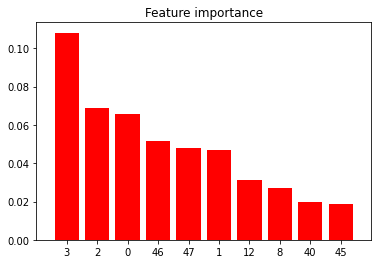

In [ ]:
# Choose Atlas (here HAMMERS)
X=T1HAMMERS # T1AAL2, T1AICHA, T1HAMMERS
labels=ROIlabelsHAMMERS # ROIlabelsAAL2, ROIlabelsAICHA, ROIlabelsHAMMERS
atlas='./AtlasHAMMERS.nii' #AtlasAAL2.nii, AtlasAICHA.nii, AtlasHAMMERS.nii

N,M = X.shape # number subjects and ROIs
class_names = ["control","alzheimer"] # y=0, y=1

print('Number of controls and Alzheimer patients is respectively: {0} and {1}'.format(N-np.sum(y), np.sum(y)))
print('Number of ROI (features) is: {0}'.format(M))

plotting.plot_roi(atlas, title=atlas)
plotting.show()

# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, np.ravel(y), test_size=0.33, random_state=42)

# We will normalize the data since it is positive
normalizer = MinMaxScaler()
normalizer.fit(X_train)
X_train_normalize=normalizer.transform(X_train)
X_test_normalize=normalizer.transform(X_test)

# Random Forest
RF=RandomForestClassifier(random_state=0)
p_grid_RF = {'n_estimators': [10,15,20,25,30], 'min_samples_leaf': [2,3,4,5,6], 'max_features': ['sqrt','log2']}   

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring='balanced_accuracy', cv=5) 
grid_RF.fit(X_train_normalize, y_train)

print("Best Validation Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
print("Random Forest test score :",grid_RF.score(X_test_normalize,y_test))

# Feature ranking
best_params=grid_RF.best_params_
RF = RandomForestClassifier(min_samples_leaf=best_params["min_samples_leaf"],max_features=best_params["max_features"],n_estimators=best_params["n_estimators"], random_state=0)
RF.fit(X_train_normalize,y_train)

importances = RF.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d representing %s (%f)" % (f + 1, indices[f], labels[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importance")
plt.bar(range(10), importances[indices[0:10]], color="r", align="center")
plt.xticks(range(10), indices[0:10])
plt.xlim([-1, 10])
plt.show()